In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc

EVALUATION_FOLDER = "evaluation_minbzk"
RESULTS_FILE = "evaluation_minbzk_no_requests_minbzk_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_minbzk_keywords_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_real_words_minbzk_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_real_words_minbzk_keywords_BM25S.csv"

woo_data = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE}")

In [8]:
def process_map(n=1):
    """
    Where n is the number of pages retrieved (max 50).
    """
    results_summary = []
    thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for threshold in thresholds:
        headers = ['dossier_id', 'retrieved_dossier_id', 'confidence', 'result', 'scores']
        df = pd.DataFrame(columns=headers)

        for index, row in woo_data.iterrows():
            dossier_ids = row["retrieved_dossier_ids"].split(", ")[:n]
            unique_dossier_ids_set = set(dossier_ids)
            unique_dossier_ids_dict = {key: 0 for key in unique_dossier_ids_set}
            # If only 1 dossier has been retrieved, set confidence to 1
            if len(unique_dossier_ids_dict) <= 1:
                #  set confidence to 1
                result = {key: 1 for key in unique_dossier_ids_dict}
            else:
                # Iterate over the dossier# columns
                for key in unique_dossier_ids_dict:
                    for idx, dossier_id in enumerate(dossier_ids):
                        if key != dossier_id:
                            continue
                        unique_dossier_ids_dict[key] += dossier_ids[0:idx + 1].count(dossier_id)/(idx + 1)
                
                # Normalize values
                result = {key: value / len(dossier_ids) for key, value in unique_dossier_ids_dict.items()}

            # print(result)
            max_key = max(result, key=result.get)
            df.loc[len(df)] = [
                row['dossier_id'],
                max_key,
                result[max_key],
                "N/A" if result[max_key] < threshold else row['dossier_id'] == max_key,
                str(result)
            ]

        true_count = df['result'].value_counts().get(True, 0)
        false_count = df['result'].value_counts().get(False, 0)
        na_count = df['result'].value_counts().get("N/A", 0)

        print(f"Threshold: {threshold}, True: {true_count}, False: {false_count}, N/A: {na_count}")
        results_summary.append({
            'Threshold': threshold,
            'True': true_count,
            'False': false_count,
            'N/A': na_count
        })
    return results_summary

def process_map_roc(n=1):
    results_summary = []
    threshold_size = 100
    thresholds = [i / (threshold_size - 1) for i in range(threshold_size)]

    for threshold in thresholds:
        first_result_true = []
        first_result_false = []

        for index, row in woo_data.iterrows():
            # Get MAP
            dossier_ids = row["retrieved_dossier_ids"].split(", ")[:n]
            unique_dossier_ids_set = set(dossier_ids)
            unique_dossier_ids_dict = {key: 0 for key in unique_dossier_ids_set}

            if len(unique_dossier_ids_dict) <= 1:
                result = {key: 1.0 for key in unique_dossier_ids_dict}
            else:
                for key in unique_dossier_ids_dict:
                    for idx, dossier_id in enumerate(dossier_ids):
                        if key != dossier_id:
                            continue
                        unique_dossier_ids_dict[key] += dossier_ids[0:idx + 1].count(dossier_id)/(idx + 1)
                # Divide result by #dossierids
                result = {key: value / len(dossier_ids) for key, value in unique_dossier_ids_dict.items()}

            # Iterate through dossier columns based on the provided `n`
            for i in range(1, n + 1):
                dossier_col_name = f'dossier#{i}'
                if dossier_col_name in row:
                    if row[dossier_col_name] == True:
                        first_result_true.append(result.get(dossier_ids[i-1], 0))
                    else:
                        first_result_false.append(result.get(dossier_ids[i-1], 0))

        tp_count = sum(1 for x in first_result_true if x >= threshold)
        fp_count = sum(1 for x in first_result_false if x >= threshold)
        fn_count = sum(1 for x in first_result_true if x < threshold)
        tn_count = sum(1 for x in first_result_false if x < threshold)
        results_summary.append({
            'Threshold': threshold,
            'tp': tp_count,
            'fp': fp_count,
            'fn': fn_count,
            'tn': tn_count
        })

    return results_summary

def create_roc_auc(results, n):
    # Calculate TPR and FPR
    tpr = [d['tp'] / (d['tp'] + d['fn']) for d in results]
    fpr = [(d['fp'] / (d['fp'] + d['tn']) if (d['fp'] + d['tn']) != 0 else 0) for d in results]

    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, marker='o')
    plt.title(f'ROC Curve MAP for n = {n}')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.grid(True)
    plt.show()

    print(f"The AUC for the ROC curve is: {auc(fpr, tpr):.8f}")

Threshold: 0.0, True: 207, False: 34, N/A: 0
Threshold: 0.1, True: 207, False: 34, N/A: 0
Threshold: 0.2, True: 207, False: 34, N/A: 0
Threshold: 0.3, True: 207, False: 34, N/A: 0
Threshold: 0.4, True: 207, False: 34, N/A: 0
Threshold: 0.5, True: 207, False: 34, N/A: 0
Threshold: 0.6, True: 207, False: 34, N/A: 0
Threshold: 0.7, True: 207, False: 34, N/A: 0
Threshold: 0.8, True: 207, False: 34, N/A: 0
Threshold: 0.9, True: 207, False: 34, N/A: 0
Threshold: 1.0, True: 207, False: 34, N/A: 0


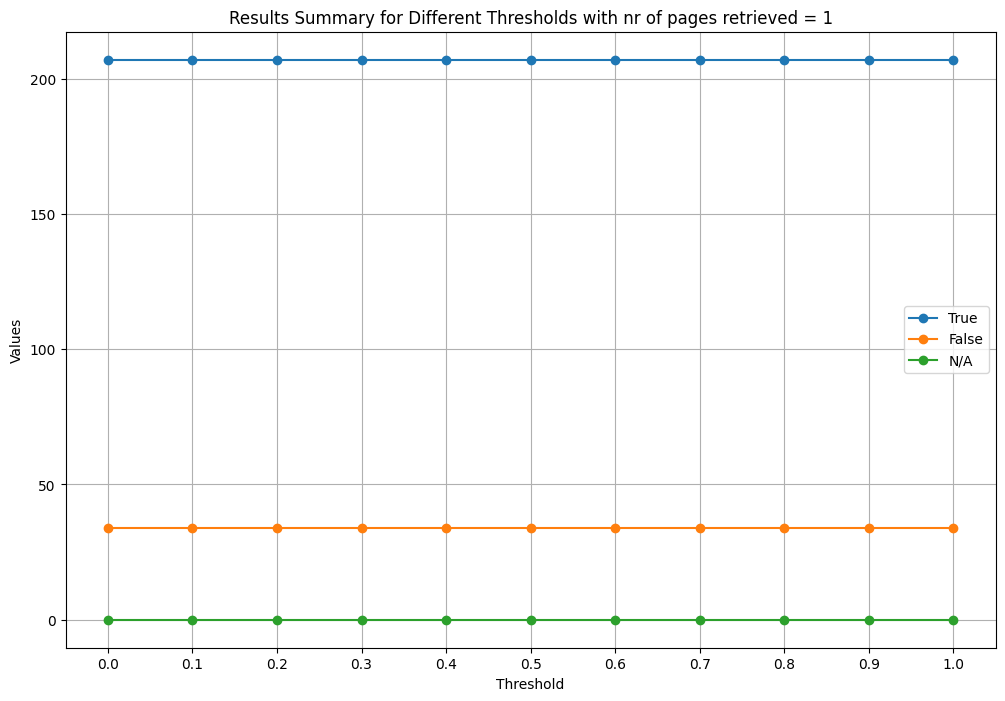

Threshold: 0.0, True: 204, False: 37, N/A: 0
Threshold: 0.1, True: 204, False: 37, N/A: 0
Threshold: 0.2, True: 198, False: 14, N/A: 29
Threshold: 0.3, True: 192, False: 8, N/A: 41
Threshold: 0.4, True: 180, False: 1, N/A: 60
Threshold: 0.5, True: 173, False: 1, N/A: 67
Threshold: 0.6, True: 166, False: 0, N/A: 75
Threshold: 0.7, True: 156, False: 0, N/A: 85
Threshold: 0.8, True: 152, False: 0, N/A: 89
Threshold: 0.9, True: 144, False: 0, N/A: 97
Threshold: 1.0, True: 140, False: 0, N/A: 101


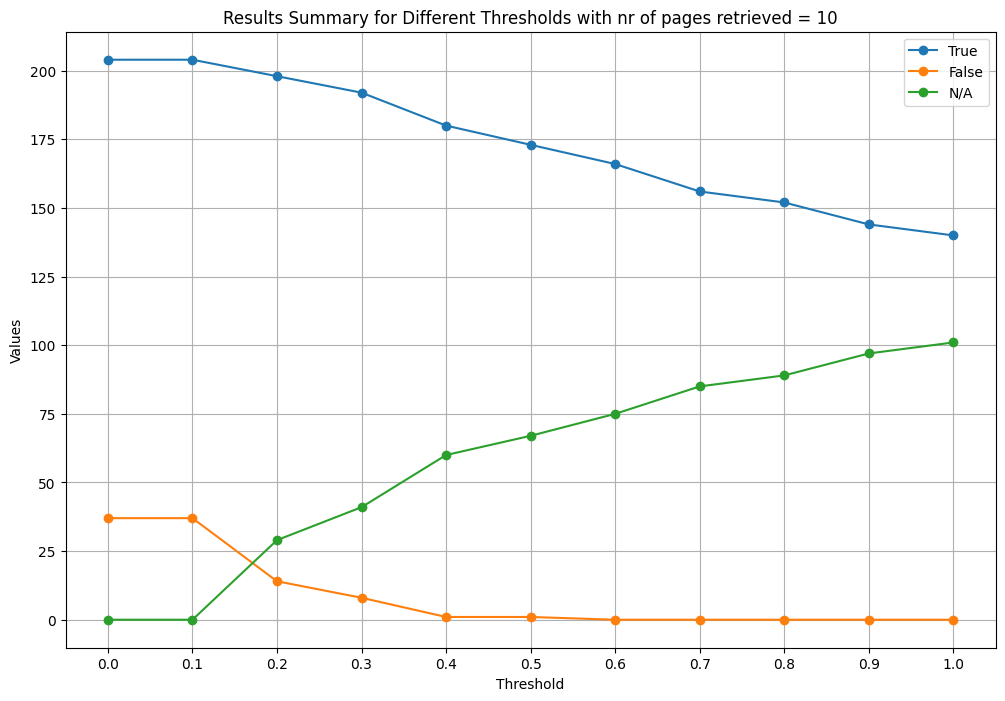

Threshold: 0.0, True: 201, False: 40, N/A: 0
Threshold: 0.1, True: 195, False: 18, N/A: 28
Threshold: 0.2, True: 183, False: 10, N/A: 48
Threshold: 0.3, True: 177, False: 6, N/A: 58
Threshold: 0.4, True: 166, False: 0, N/A: 75
Threshold: 0.5, True: 159, False: 0, N/A: 82
Threshold: 0.6, True: 147, False: 0, N/A: 94
Threshold: 0.7, True: 137, False: 0, N/A: 104
Threshold: 0.8, True: 129, False: 0, N/A: 112
Threshold: 0.9, True: 117, False: 0, N/A: 124
Threshold: 1.0, True: 110, False: 0, N/A: 131


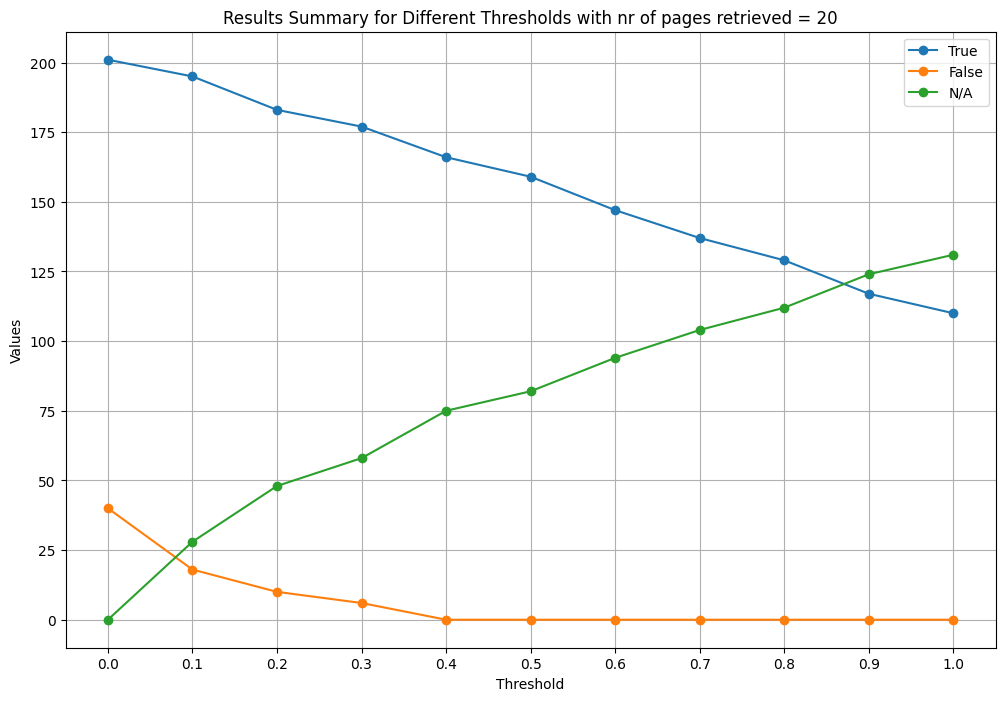

Threshold: 0.0, True: 201, False: 40, N/A: 0
Threshold: 0.1, True: 192, False: 15, N/A: 34
Threshold: 0.2, True: 178, False: 10, N/A: 53
Threshold: 0.3, True: 168, False: 4, N/A: 69
Threshold: 0.4, True: 156, False: 2, N/A: 83
Threshold: 0.5, True: 140, False: 0, N/A: 101
Threshold: 0.6, True: 133, False: 0, N/A: 108
Threshold: 0.7, True: 125, False: 0, N/A: 116
Threshold: 0.8, True: 110, False: 0, N/A: 131
Threshold: 0.9, True: 99, False: 0, N/A: 142
Threshold: 1.0, True: 88, False: 0, N/A: 153


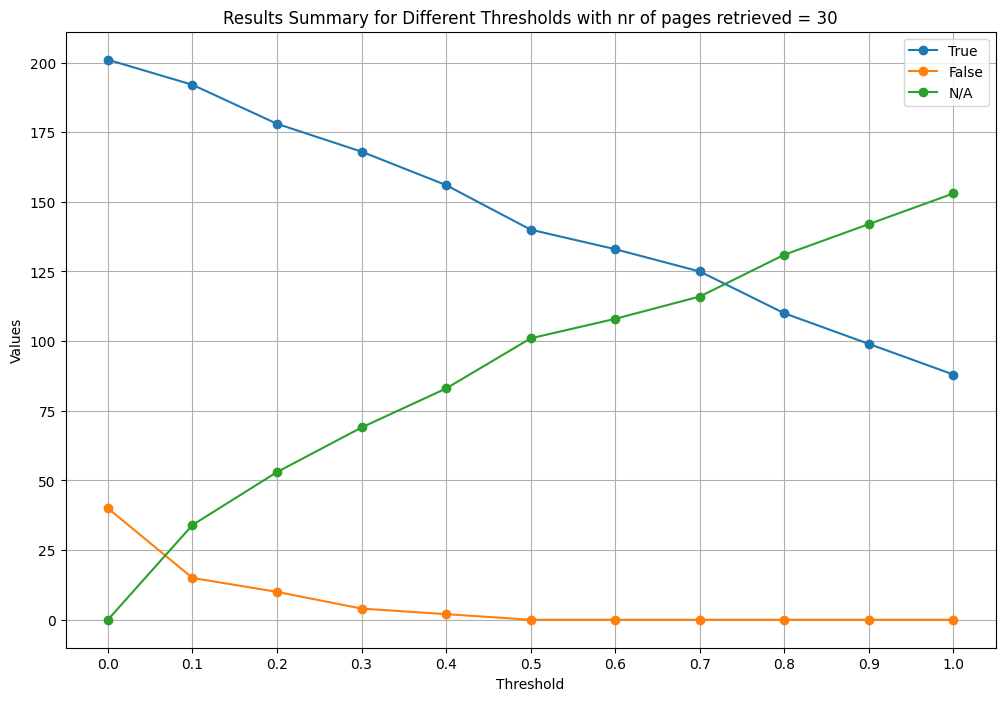

Threshold: 0.0, True: 200, False: 41, N/A: 0
Threshold: 0.1, True: 184, False: 13, N/A: 44
Threshold: 0.2, True: 173, False: 9, N/A: 59
Threshold: 0.3, True: 160, False: 3, N/A: 78
Threshold: 0.4, True: 143, False: 2, N/A: 96
Threshold: 0.5, True: 135, False: 1, N/A: 105
Threshold: 0.6, True: 124, False: 0, N/A: 117
Threshold: 0.7, True: 109, False: 0, N/A: 132
Threshold: 0.8, True: 101, False: 0, N/A: 140
Threshold: 0.9, True: 88, False: 0, N/A: 153
Threshold: 1.0, True: 75, False: 0, N/A: 166


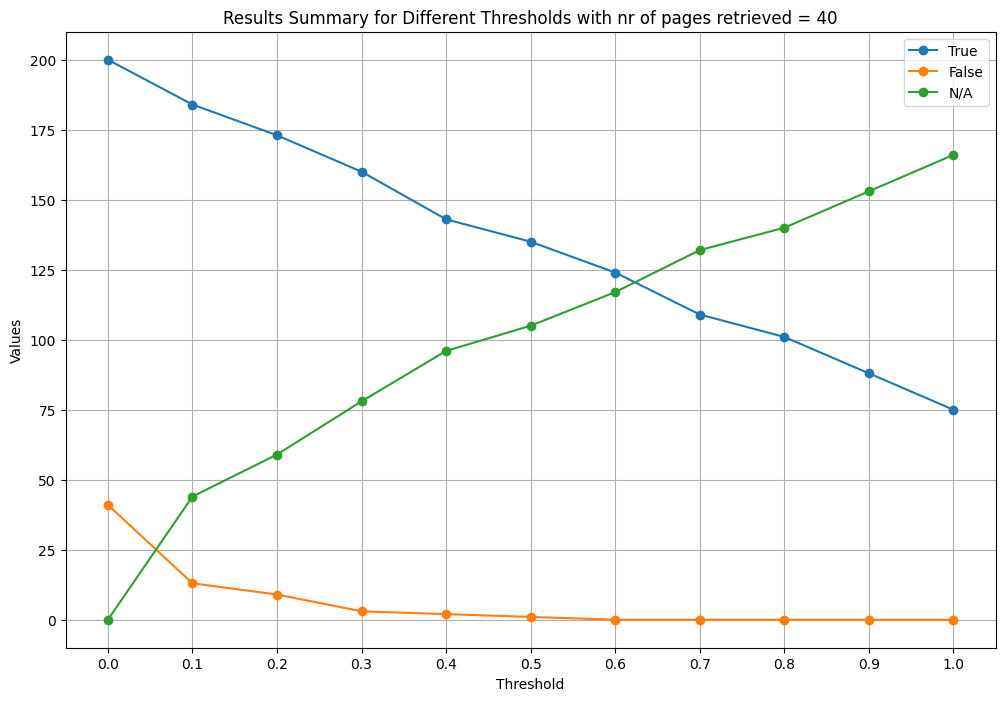

Threshold: 0.0, True: 199, False: 42, N/A: 0
Threshold: 0.1, True: 181, False: 11, N/A: 49
Threshold: 0.2, True: 169, False: 9, N/A: 63
Threshold: 0.3, True: 148, False: 2, N/A: 91
Threshold: 0.4, True: 138, False: 2, N/A: 101
Threshold: 0.5, True: 123, False: 1, N/A: 117
Threshold: 0.6, True: 110, False: 0, N/A: 131
Threshold: 0.7, True: 102, False: 0, N/A: 139
Threshold: 0.8, True: 90, False: 0, N/A: 151
Threshold: 0.9, True: 80, False: 0, N/A: 161
Threshold: 1.0, True: 64, False: 0, N/A: 177


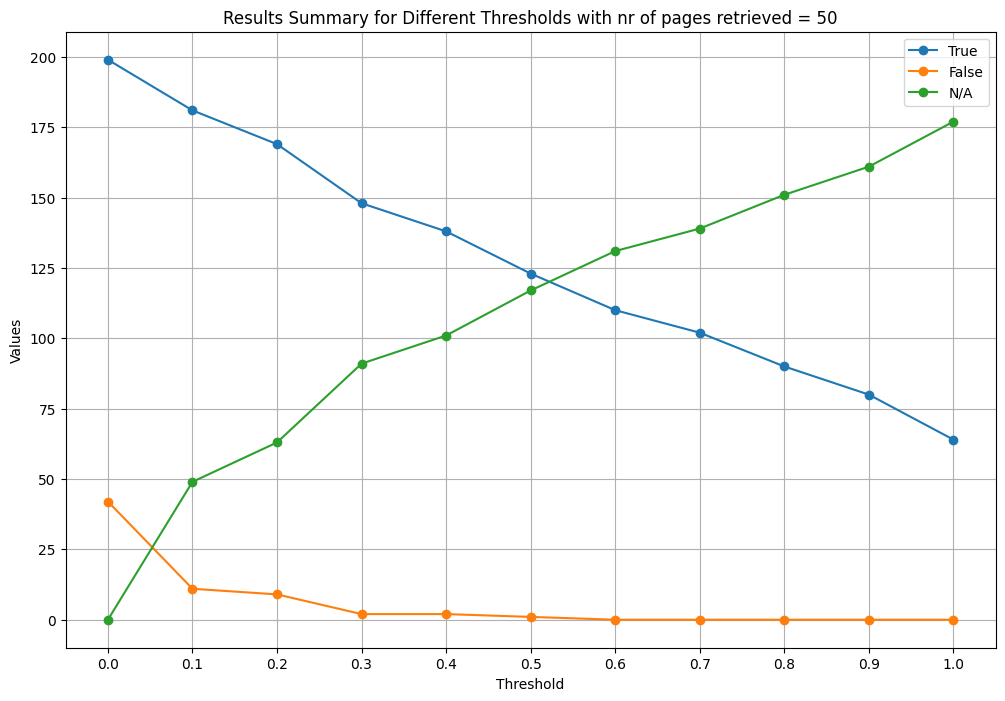

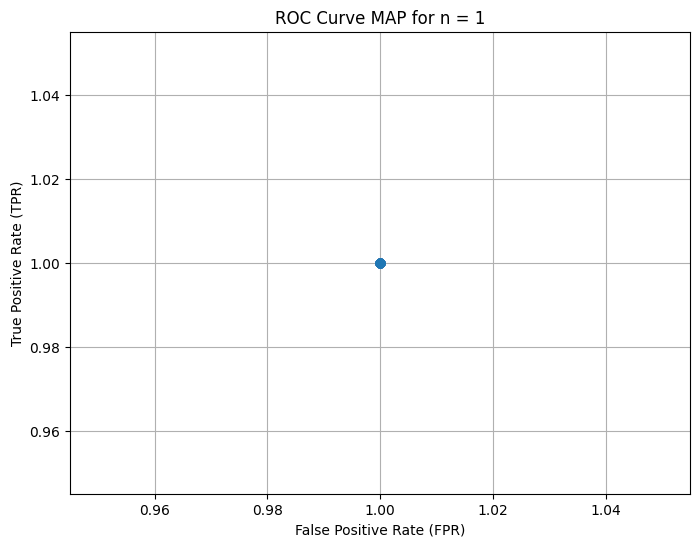

The AUC for the ROC curve is: 0.00000000


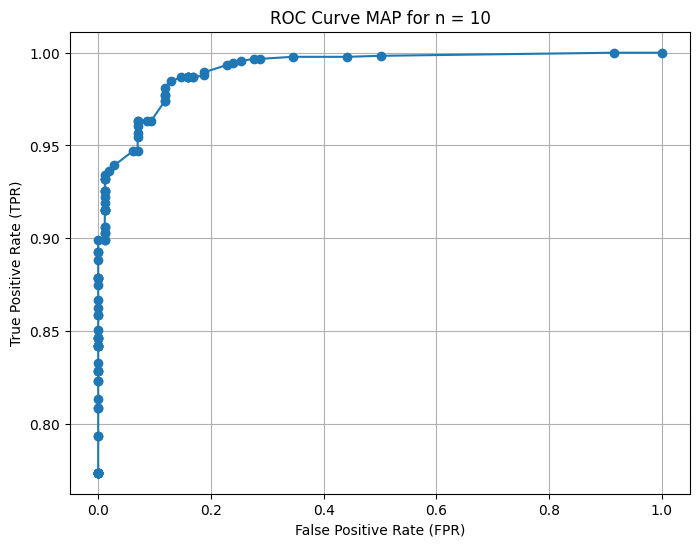

The AUC for the ROC curve is: 0.99136556


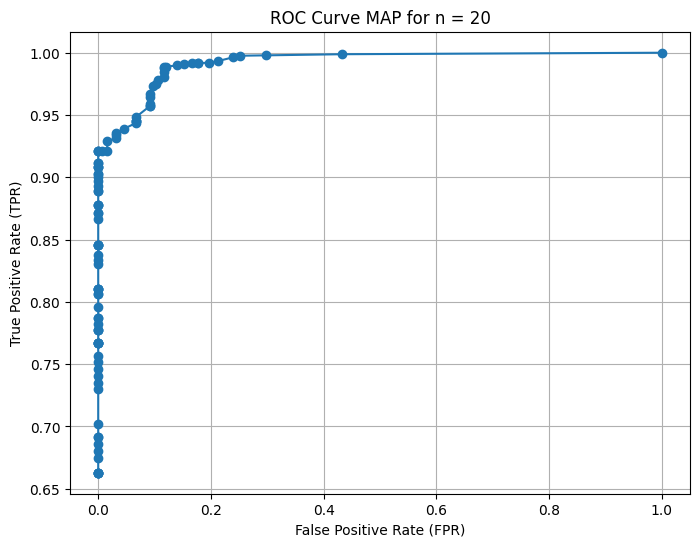

The AUC for the ROC curve is: 0.99203986


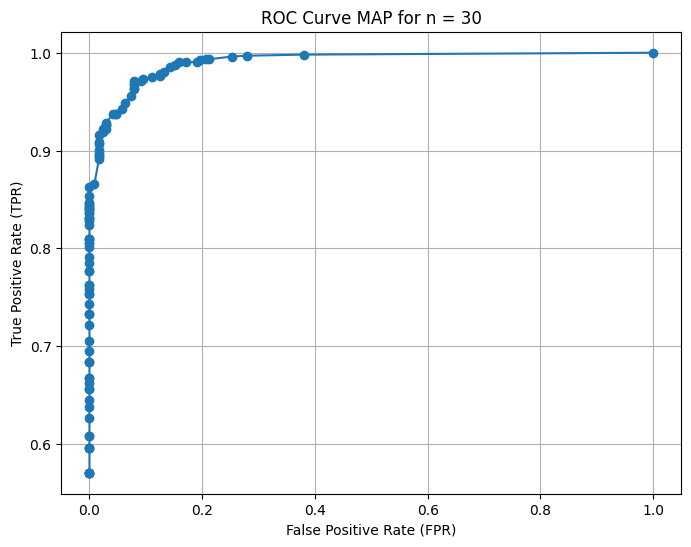

The AUC for the ROC curve is: 0.99060717


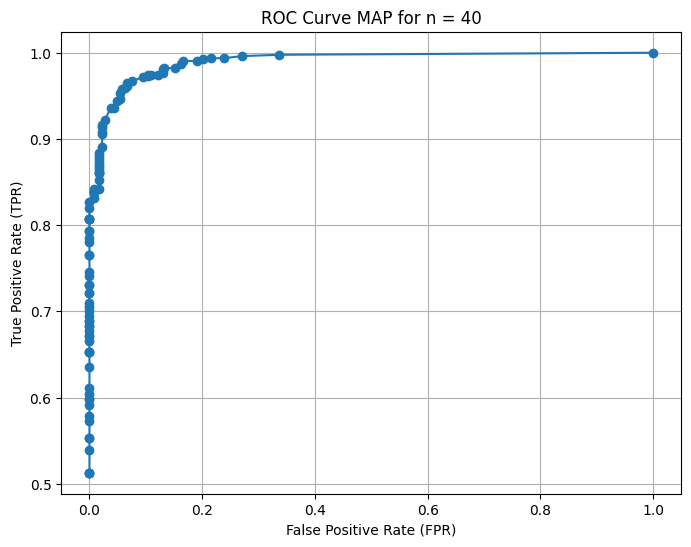

The AUC for the ROC curve is: 0.98984259


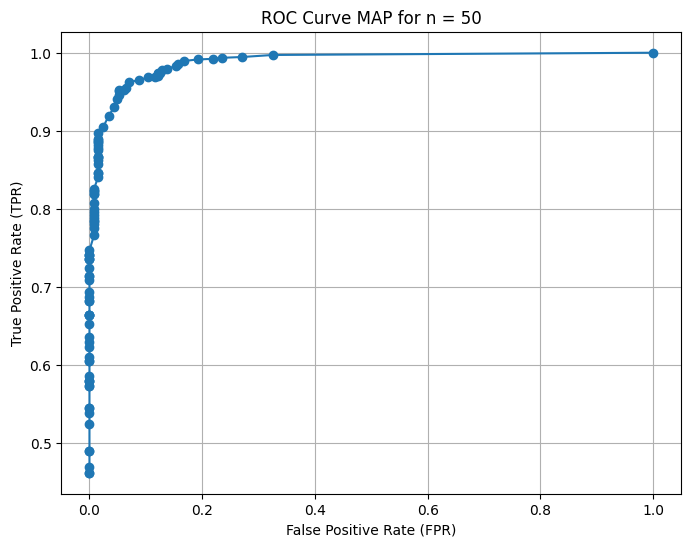

The AUC for the ROC curve is: 0.98842628


In [9]:
dossier_id_limits = [1, 10, 20, 30, 40, 50]
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Normal
for i in dossier_id_limits:
    results_df = pd.DataFrame(process_map(i))
    plt.figure(figsize=(12, 8))

    plt.plot(results_df['Threshold'], results_df['True'], marker='o', label='True')
    plt.plot(results_df['Threshold'], results_df['False'], marker='o', label='False')
    plt.plot(results_df['Threshold'], results_df['N/A'], marker='o', label='N/A')

    plt.title(f'Results Summary for Different Thresholds with nr of pages retrieved = {i}')
    plt.xlabel('Threshold')
    plt.ylabel('Values')
    plt.xticks(thresholds)
    plt.grid(True)
    plt.legend()
    plt.show()

# ROC
for i in dossier_id_limits:
    results = process_map_roc(i)
    create_roc_auc(results, i)
